In [5]:
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from model import MambaFull

index_to_color = {0:'white',1: 'red', 2: 'green', 3: 'blue', 4: 'yellow', 5: 'purple',6:'black'}

def generate_data(batch_size=100):
    rand_index_list = np.array([sorted(np.random.choice(range(1, 20), 5, replace=False)) for _ in range(batch_size)])
    colors = np.random.choice(range(1,6), (batch_size,5))
    target = np.zeros((batch_size,25))
    target[:, 20:] = colors
    data = np.zeros((batch_size,25))
    data[np.arange(batch_size)[:, None], rand_index_list] = colors
    data[:, 20:] = 6
    return [data, target]

data = generate_data(batch_size=100)
print(data[0][0],data[1][0])

[0. 2. 0. 0. 0. 0. 0. 0. 3. 1. 0. 0. 0. 0. 3. 0. 0. 3. 0. 0. 6. 6. 6. 6.
 6.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 3. 1. 3.
 3.]


  0%|          | 6/50001 [00:00<13:56, 59.75it/s]

Epoch 0: loss=1.975183129310608


 10%|█         | 5015/50001 [00:36<05:18, 141.39it/s]

Epoch 5000: loss=1.2243884801864624


 20%|██        | 10028/50001 [01:10<04:33, 146.17it/s]

Epoch 10000: loss=1.1828726530075073


 30%|███       | 15023/50001 [01:44<04:01, 144.92it/s]

Epoch 15000: loss=1.1678493022918701


 40%|████      | 20017/50001 [02:17<03:13, 154.60it/s]

Epoch 20000: loss=1.1660354137420654


 50%|█████     | 25017/50001 [02:51<02:45, 151.29it/s]

Epoch 25000: loss=1.1656135320663452


 60%|██████    | 30023/50001 [03:24<02:15, 146.91it/s]

Epoch 30000: loss=1.1654261350631714


 70%|███████   | 35025/50001 [03:58<01:40, 149.04it/s]

Epoch 35000: loss=1.1654248237609863


 80%|████████  | 40024/50001 [04:33<01:11, 139.95it/s]

Epoch 40000: loss=1.1654222011566162


 90%|█████████ | 45019/50001 [05:07<00:34, 146.02it/s]

Epoch 45000: loss=1.1654233932495117


100%|██████████| 50001/50001 [05:41<00:00, 146.21it/s]


Epoch 50000: loss=1.1654222011566162


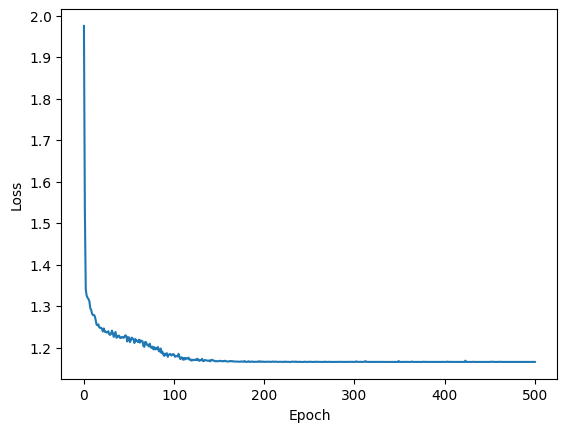

In [7]:
# Define model parameters
args = {
    'd_model':64,
    'vocab_size':7, 
    'n_layer':2,
}

seed = 402
torch.manual_seed(seed)
np.random.seed(seed)
        

model = MambaFull(args)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define a loss function
loss_fn = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = Adam(model.parameters(), lr=1e-4)

# List to store loss values
loss_values = []
best_loss = float('inf')

# For each epoch
for epoch in tqdm(range(50001)):
    # Generate data
    inputs, targets = generate_data(batch_size=64)
    inputs = torch.from_numpy(inputs).long().to(device)
    targets = torch.from_numpy(targets).long().to(device)
    outputs = model(inputs)
    outputs = nn.Softmax(dim=2)(outputs)
    loss = loss_fn(outputs.reshape(-1,7), targets.reshape(-1))
    if epoch % 100 == 0:
      loss_values.append(loss.item())  # Store loss value
    if epoch % 5000 == 0:
        print(f'Epoch {epoch}: loss={loss.item()}')

    # Backward pass: compute the gradients of the loss with respect to the model's parameters
    loss.backward()

    # Update the model's parameters
    optimizer.step()

    # Zero the gradients
    optimizer.zero_grad()

    # Save checkpoint every 10,000 epochs
    if loss.item() < best_loss:
        best_loss = loss.item()
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
        }
        torch.save(checkpoint, 'best_checkpoint.pt')
# Plot loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
print(sum(p.numel() for p in model.parameters()))
inputs, targets = generate_data(batch_size=1)
inputs = torch.from_numpy(inputs).long().to(device)
targets = torch.from_numpy(targets).long().to(device)
outputs = model(inputs)
outputs = nn.Softmax(dim=2)(outputs)
print(inputs[0])
print(outputs[0].argmax(dim=1))
print(targets[0])

66368
tensor([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 6, 6, 6, 6,
        6], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
        2], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
        2], device='cuda:0')
